In [1]:
import cv2,os
from skimage import io
import numpy as np
from tqdm import tqdm 
from matplotlib import pyplot as plt

In [11]:
chip="Hoechst"

In [23]:
X_Ctrl = np.load("./Datasets/Ctrl_"+chip+".npy",allow_pickle=True)
X_VPA = np.load("./Datasets/VPA_"+chip+".npy",allow_pickle=True)

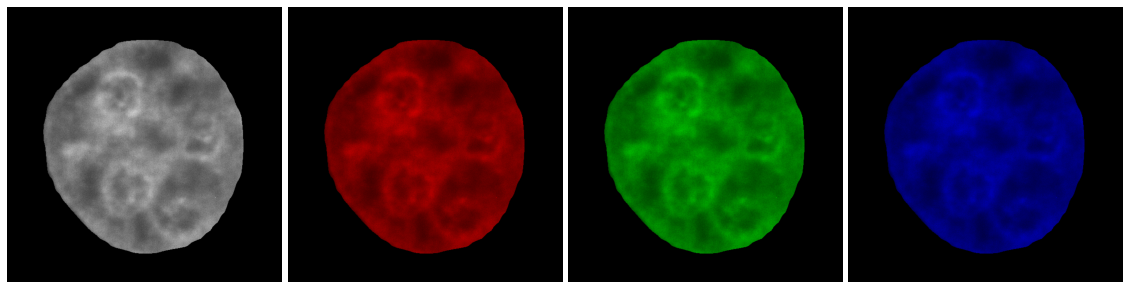

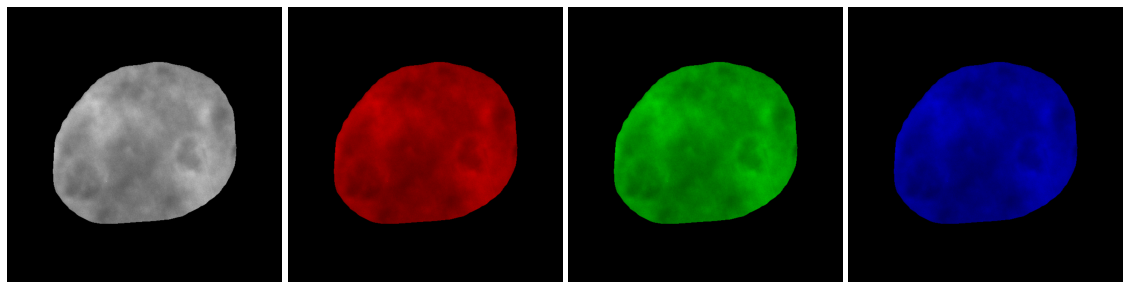

In [24]:
def title(label):
    if label==0:
        return "untreated"
    else:
        return "VPA-treated"
img = X_Ctrl[23]
b,g,r=cv2.split(img)
r,g,b=r/r.max(),g/g.max(),b/b.max()
img=cv2.merge((r,g,b))
zero=np.zeros([600,600])
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(img/img.max())
plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(cv2.merge([r,zero,zero]))
plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(cv2.merge([zero,g,zero]))
plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(cv2.merge([zero,zero,b]))

img = X_VPA[19]
b,g,r=cv2.split(img)
r,g,b=r/r.max(),g/g.max(),b/b.max()
img=cv2.merge((r,g,b))
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(img/img.max())
plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(cv2.merge([r,zero,zero]))
plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(cv2.merge([zero,g,zero]))
plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(cv2.merge([zero,zero,b]))

# Read Path 

In [5]:
path_Ctrl = "../../Datasets/221206SoRa/Single_Ctrl/"
path_VPA = "../../Datasets/221206SoRa/Single_VPA/"

In [6]:
DataPath_Ctrl=[]

for root,dirs,files in os.walk(path_Ctrl):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath_Ctrl.append(path)
        
print("len(DataPath_Ctrl):",len(DataPath_Ctrl))

############################################################

DataPath_VPA=[]

for root,dirs,files in os.walk(path_VPA):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath_VPA.append(path)
        
print("len(DataPath_VPA):",len(DataPath_VPA))

len(DataPath_Ctrl): 3225
len(DataPath_VPA): 3689


*********

# Read Image

In [10]:
img_Ctrl=[]
for i in tqdm(range(len(DataPath_Ctrl))):
    img = io.imread(DataPath_Ctrl[i])
    img_Ctrl.append(img)
    
img_Ctrl = np.array(img_Ctrl)
np.save("./Datasets/img_Ctrl.npy",img_Ctrl,'dtype=object')

In [11]:
img_VPA=[]
for i in tqdm(range(len(DataPath_VPA))):
    img = io.imread(DataPath_VPA[i])
    img_VPA.append(img)
    
img_VPA = np.array(img_VPA)
np.save("./Datasets/img_VPA.npy",img_VPA,'dtype=object')

*********

# Data preprocessing

In [14]:
Data_Ctrl=np.load("./Datasets/img_Ctrl.npy",allow_pickle=True)
Data_VPA=np.load("./Datasets/img_VPA.npy",allow_pickle=True)
print("img_Ctrl.shape:", Data_Ctrl.shape)
print("img_VPA.shape:", Data_VPA.shape)

img_Ctrl.shape: (3225,)
img_VPA.shape: (3689,)


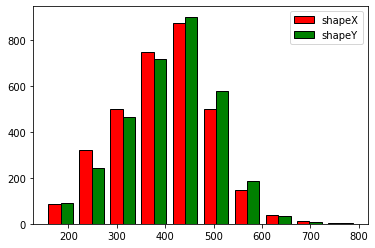

In [15]:
shapeX=[]
shapeY=[]
for i in range(len(Data_Ctrl)):
    shapeX.append(Data_Ctrl[i].shape[0])
    shapeY.append(Data_Ctrl[i].shape[1])
fig, ax = plt.subplots()
ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[min(min(shapeX,shapeY)),max(max(shapeX,shapeY))])
ax.legend()

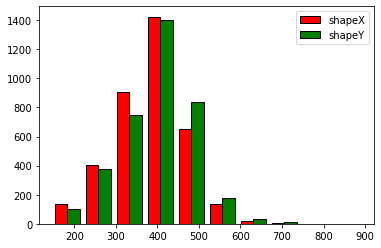

In [16]:
shapeX=[]
shapeY=[]
for i in range(len(Data_VPA)):
    shapeX.append(Data_VPA[i].shape[0])
    shapeY.append(Data_VPA[i].shape[1])
fig, ax = plt.subplots()
ax.hist([shapeX,shapeY], label=["shapeX", "shapeY"], color=["r", "g"], ec="k",range=[min(min(shapeX,shapeY)),max(max(shapeX,shapeY))])
ax.legend()

## padding 

In [17]:
#　同じサイズにする
def datapadding(img):
    imgSize = img.shape
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
    return img_pad

In [23]:
Max_shape_0=600
Max_shape_1=600
min_shape_0=200
min_shape_1=200

In [24]:
num=0
final_01=[]
for n in range(len(Data_Ctrl)):
    img = Data_Ctrl[n]
    if min_shape_0<=img.shape[0]<=Max_shape_0 and min_shape_1<=img.shape[1]<=Max_shape_1:
        num+=1
        final_01.append(datapadding(img))
final_01=np.array(final_01)
print(final_01.shape)


num=0
final_02=[]
for n in range(len(Data_VPA)):
    img = Data_VPA[n]
    if min_shape_0<=img.shape[0]<=Max_shape_0 and min_shape_1<=img.shape[1]<=Max_shape_1:
        num+=1
        final_02.append(datapadding(img))
final_02=np.array(final_02)
print(final_02.shape)

(3046, 600, 600, 3)
(3516, 600, 600, 3)


In [27]:
np.save("./Datasets/Ctrl_pad_uint16.npy",final_01)
np.save("./Datasets/VPA_pad_uint16.npy",final_02)

# split train and test

In [31]:
def NormToUint8(img):
    img_uint8 = img - img.min()
    img_uint8 = img_uint8 / (img_uint8.max() - img_uint8.min())
    img_uint8 *= 255
    return img_uint8.astype(np.uint8)

In [29]:
Data_Ctrl=np.load("./Datasets/Ctrl_pad_uint16.npy",allow_pickle=True)
Data_VPA=np.load("./Datasets/VPA_pad_uint16.npy",allow_pickle=True)

print("Data_Ctrl.shape:", Data_Ctrl.shape, " dtype: ", Data_Ctrl.dtype)
print("Data_VPA.shape:", Data_VPA.shape, " dtype: ", Data_VPA.dtype)

Data_Ctrl.shape: (3046, 600, 600, 3)  dtype:  uint16
Data_VPA.shape: (3516, 600, 600, 3)  dtype:  uint16


In [33]:
Data_Ctrl_uint8=[]
for img in Data_Ctrl:
    Data_Ctrl_uint8.append(NormToUint8(img))
Data_Ctrl_uint8=np.array(Data_Ctrl_uint8)
np.save("./Datasets/Ctrl_pad_uint8.npy",Data_Ctrl_uint8)
print("Data_Ctrl_uint8.shape:", Data_Ctrl_uint8.shape, " dtype: ", Data_Ctrl_uint8.dtype)

Data_VPA_uint8=[]
for img in Data_VPA:
    Data_VPA_uint8.append(NormToUint8(img))
Data_VPA_uint8=np.array(Data_VPA_uint8)
np.save("./Datasets/VPA_pad_uint8.npy",Data_VPA_uint8)
print("Data_VPA_uint8.shape:", Data_VPA_uint8.shape, " dtype: ", Data_VPA_uint8.dtype)

Data_Ctrl_uint8.shape: (3046, 600, 600, 3)  dtype:  uint8
Data_VPA_uint8.shape: (3516, 600, 600, 3)  dtype:  uint8


# Split each Channel

In [16]:
Data_Ctrl=np.load("./Datasets/Ctrl_All.npy",allow_pickle=True)
Data_VPA=np.load("./Datasets/VPA_All.npy",allow_pickle=True)

print("Data_Ctrl.shape:", Data_Ctrl.shape, " dtype: ", Data_Ctrl.dtype)
print("Data_VPA.shape:", Data_VPA.shape, " dtype: ", Data_VPA.dtype)

Data_Ctrl.shape: (3046, 600, 600, 3)  dtype:  uint8
Data_VPA.shape: (3516, 600, 600, 3)  dtype:  uint8


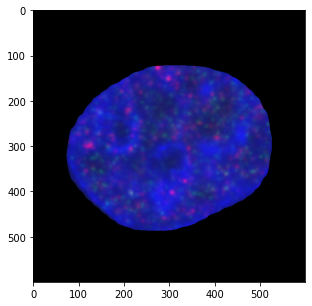

In [17]:
plt.figure(figsize=(5,5))
im = Data_Ctrl[44]
r,g,b = cv2.split(im)
im = cv2.merge([b,g,r])
plt.imshow(im)

In [3]:
Ctrl_H3K27ac = []
Ctrl_CTCF = []
Ctrl_Hoechst = []
for img in Data_Ctrl:
    img_H3K27ac = img[:,:,2]
    img_CTCF = img[:,:,1]
    img_Hoechst = img[:,:,0]
    img_H3K27ac = cv2.merge([img_H3K27ac,img_H3K27ac,img_H3K27ac])
    img_CTCF = cv2.merge([img_CTCF,img_CTCF,img_CTCF])
    img_Hoechst = cv2.merge([img_Hoechst,img_Hoechst,img_Hoechst])
    Ctrl_H3K27ac.append(img_H3K27ac)
    Ctrl_CTCF.append(img_CTCF)
    Ctrl_Hoechst.append(img_Hoechst)

In [4]:
Ctrl_H3K27ac = np.array(Ctrl_H3K27ac)
Ctrl_CTCF = np.array(Ctrl_CTCF)
Ctrl_Hoechst = np.array(Ctrl_Hoechst)
np.save("./Datasets/Ctrl_H3K27ac.npy",Ctrl_H3K27ac)
np.save("./Datasets/Ctrl_CTCF.npy",Ctrl_CTCF)
np.save("./Datasets/Ctrl_Hoechst.npy",Ctrl_Hoechst)

In [5]:
VPA_H3K27ac = []
VPA_CTCF = []
VPA_Hoechst = []
for img in Data_VPA:
    img_H3K27ac = img[:,:,2]
    img_CTCF = img[:,:,1]
    img_Hoechst = img[:,:,0]
    img_H3K27ac = cv2.merge([img_H3K27ac,img_H3K27ac,img_H3K27ac])
    img_CTCF = cv2.merge([img_CTCF,img_CTCF,img_CTCF])
    img_Hoechst = cv2.merge([img_Hoechst,img_Hoechst,img_Hoechst])
    VPA_H3K27ac.append(img_H3K27ac)
    VPA_CTCF.append(img_CTCF)
    VPA_Hoechst.append(img_Hoechst)

In [6]:
VPA_H3K27ac = np.array(VPA_H3K27ac)
VPA_CTCF = np.array(VPA_CTCF)
VPA_Hoechst = np.array(VPA_Hoechst)
np.save("./Datasets/VPA_H3K27ac.npy",VPA_H3K27ac)
np.save("./Datasets/VPA_CTCF.npy",VPA_CTCF)
np.save("./Datasets/VPA_Hoechst.npy",VPA_Hoechst)